<a href="https://colab.research.google.com/github/lsh3163/Cifar10Tutorial/blob/master/Cifar10Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homwerk2 : Neural Network 프레임워크로 구현

## 1. 데이터셋 준비

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cuda:0


In [11]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
# Download and load the training data
trainset = datasets.CIFAR10('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.CIFAR10('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### Plot Image

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

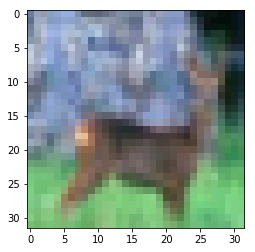

In [13]:
import matplotlib.pyplot as plt
import numpy as np
image, label = next(iter(trainloader))
imshow(image[0,:]);

## 2. 네트워크 만들기

In [0]:
from torch import nn
from torch import optim
from torch.nn import functional as F
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.batch1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.batch2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.batch3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 10)

        # 0.2정도를 무작위로 골라 dropout한다.
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.batch1(self.fc1(x))))
        x = self.dropout(F.relu(self.batch2(self.fc2(x))))
        x = self.dropout(F.relu(self.batch3(self.fc3(x))))

        # output은 dropout하면 안된다..
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [18]:
model = Classifier()
model.to(device)
# Log Softmax Classifier
criterion = nn.NLLLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999))

epochs=30
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # 0으로 초기화
        optimizer.zero_grad()
        # log_ps-> 확률값
        log_ps = model(images.to(device))
        # 손실계산
        loss = criterion(log_ps, labels.to(device))
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            # test 과정에 들어간다. dropout을 안하게 된다.
            # 정확하게 말하면, dropout 하는 비율이 0이 된다.
            model.eval()
            for images, labels in testloader:
                log_ps = model(images.to(device))
                test_loss += criterion(log_ps, labels.to(device))
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.to(device).view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # 다시 트레이닝 과정으로 돌아간다.
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/30..  Training Loss: 1.711..  Test Loss: 1.493..  Test Accuracy: 0.468
Epoch: 2/30..  Training Loss: 1.513..  Test Loss: 1.406..  Test Accuracy: 0.500
Epoch: 3/30..  Training Loss: 1.430..  Test Loss: 1.341..  Test Accuracy: 0.522
Epoch: 4/30..  Training Loss: 1.364..  Test Loss: 1.307..  Test Accuracy: 0.536
Epoch: 5/30..  Training Loss: 1.318..  Test Loss: 1.294..  Test Accuracy: 0.534
Epoch: 6/30..  Training Loss: 1.275..  Test Loss: 1.269..  Test Accuracy: 0.544
Epoch: 7/30..  Training Loss: 1.234..  Test Loss: 1.261..  Test Accuracy: 0.548
Epoch: 8/30..  Training Loss: 1.200..  Test Loss: 1.250..  Test Accuracy: 0.552
Epoch: 9/30..  Training Loss: 1.164..  Test Loss: 1.238..  Test Accuracy: 0.561
Epoch: 10/30..  Training Loss: 1.139..  Test Loss: 1.242..  Test Accuracy: 0.558
Epoch: 11/30..  Training Loss: 1.108..  Test Loss: 1.243..  Test Accuracy: 0.560
Epoch: 12/30..  Training Loss: 1.082..  Test Loss: 1.227..  Test Accuracy: 0.566
Epoch: 13/30..  Training Loss: 1.054.

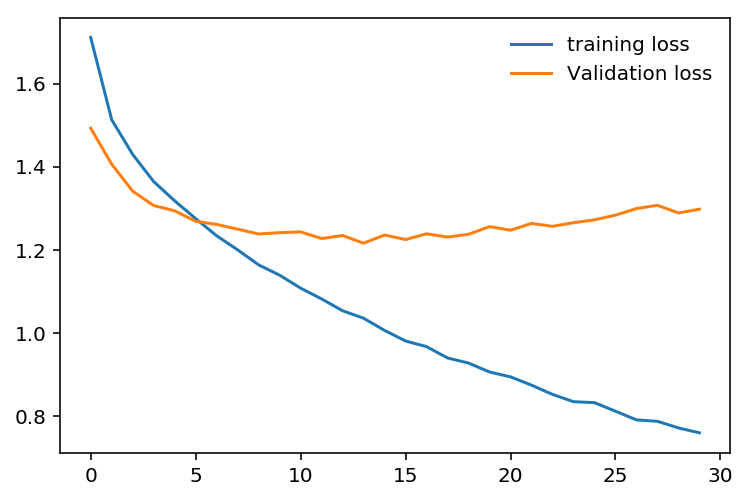

In [19]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Data Augmentation

In [0]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.RandomRotation(20),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [21]:
# Download and load the training data
trainset = datasets.CIFAR10('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.CIFAR10('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
model = Classifier()
model.to(device)
# Log Softmax Classifier
criterion = nn.NLLLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999))

epochs=30
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # 0으로 초기화
        optimizer.zero_grad()
        # log_ps-> 확률값
        # Image를 GPU에 올리자
        log_ps = model(images.to(device))
        # 손실계산
        # labels를 GPU에 올리자
        loss = criterion(log_ps, labels.to(device))
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            # test 과정에 들어간다. dropout을 안하게 된다.
            # 정확하게 말하면, dropout 하는 비율이 0이 된다.
            model.eval()
            for images, labels in testloader:
                log_ps = model(images.to(device))
                test_loss += criterion(log_ps, labels.to(device))
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.to(device).view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # 다시 트레이닝 과정으로 돌아간다.
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/30..  Training Loss: 1.765..  Test Loss: 1.550..  Test Accuracy: 0.442
Epoch: 2/30..  Training Loss: 1.592..  Test Loss: 1.474..  Test Accuracy: 0.474
Epoch: 3/30..  Training Loss: 1.522..  Test Loss: 1.426..  Test Accuracy: 0.488
Epoch: 4/30..  Training Loss: 1.476..  Test Loss: 1.389..  Test Accuracy: 0.505
Epoch: 5/30..  Training Loss: 1.438..  Test Loss: 1.369..  Test Accuracy: 0.512
Epoch: 6/30..  Training Loss: 1.410..  Test Loss: 1.327..  Test Accuracy: 0.522
Epoch: 7/30..  Training Loss: 1.382..  Test Loss: 1.333..  Test Accuracy: 0.520
Epoch: 8/30..  Training Loss: 1.362..  Test Loss: 1.297..  Test Accuracy: 0.536
Epoch: 9/30..  Training Loss: 1.345..  Test Loss: 1.288..  Test Accuracy: 0.542
Epoch: 10/30..  Training Loss: 1.324..  Test Loss: 1.287..  Test Accuracy: 0.541
Epoch: 11/30..  Training Loss: 1.306..  Test Loss: 1.265..  Test Accuracy: 0.547
Epoch: 12/30..  Training Loss: 1.296..  Test Loss: 1.253..  Test Accuracy: 0.555
Epoch: 13/30..  Training Loss: 1.287.

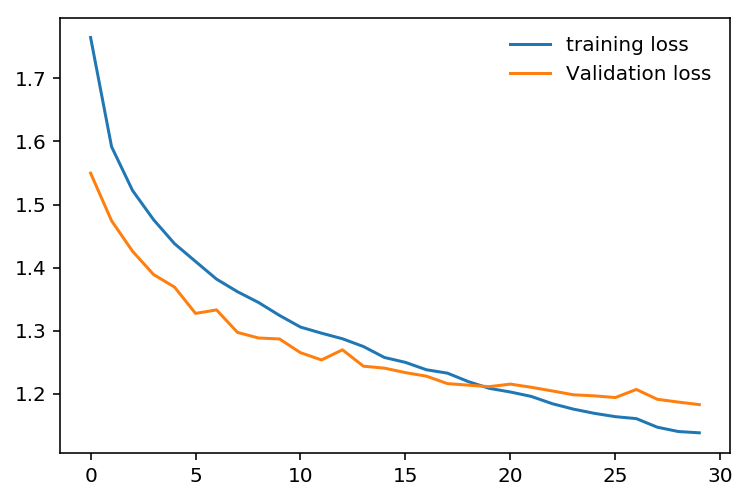

In [23]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)